## Createtime analysis to find chunks of twitter bots

This notebook performs a simple analysis of the seques of times at which Twitter follower accounts were created. It is the idea behind the plots in the NY Times "Follower factory" story from Jan 27, 2018:
https://www.nytimes.com/interactive/2018/01/27/technology/social-media-bots.html

Running the notebook requires a set of tokens for the Twitter API. To get your own tokens, see here:
https://developer.twitter.com/en/docs/basics/authentication/overview

I don't recommend trying to use this notebook unless you have a solid general understanding of python and web APIs, but still wanted to put it out there. Unless you have very good tokens, your patience will be severely tests if you try to use this notebook to look at users with >200k followers. So consider yourself advised.

In [1]:
import sys
import string
import simplejson
from twython import Twython
import matplotlib
import matplotlib.pyplot as plt

from datetime import datetime
from dateutil import parser
import time

#FOR OAUTH AUTHENTICATION -- NEEDED TO ACCESS THE TWITTER API
t = Twython(app_key='APP_KEY', 
    app_secret='APP_SECRET',
    oauth_token='OAUTH_TOKEN',
    oauth_token_secret='OAUTH_TOKEN_SECRET')

In [2]:
def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

In [3]:
# ego_screenname -- the person you're looking to query for
#ego_screenname = "jugander"

# "Bot scholars" that may be useful to look at
ego_screenname = "gilgul"
#ego_screenname = "suneman"
#ego_screenname = "yy"

ego_id = t.lookup_user(screen_name=ego_screenname)[0]['id_str']

In [4]:
# Get the follower list. 
# Rate limiting caps this at ~80000 followers every 900 seconds. Hacky pauses added. 
follower_list = []
nextcurs = -1
while (nextcurs != 0):
    remaining = t.get_lastfunction_header(header='x-rate-limit-remaining')
    secs = int(t.get_lastfunction_header(header='x-rate-limit-reset')) - int(datetime.now().timestamp())
    if ((int(remaining) == 0) and (secs >= 0)):
        print("Waiting " + str(secs) + " seconds...")
        time.sleep(secs+3)
    
    follower_object = t.get_followers_ids(user_id = ego_id, count = 5000, cursor = nextcurs)
    follower_list += follower_object['ids']
    nextcurs = follower_object['next_cursor']
    print(str(len(follower_list))) 

5000
10000
15000
17981


In [5]:
# Status of API allowances from last call
print("Allowed " + str(t.get_lastfunction_header(header='x-rate-limit-remaining')) +
      " more follow requests over the next " + 
      str(int(t.get_lastfunction_header(header='x-rate-limit-reset')) - int(datetime.now().timestamp())) +
        " seconds.")

len(follower_list)

Allowed 11 more follow requests over the next 898 seconds.


17981

In [6]:
# Once you have the followers, now need to gather the create_times of those followers

# Optionally downsample
if (len(follower_list) > 20000):
    downsample_rate = 1
else:
    downsample_rate = 1

# Begin
i = downsample_rate
k = 0
ts_list_mk = []
for follower_chunk in chunker(follower_list,100):
    k += 100
    if (i == downsample_rate):
        i = 1
    else:
        i += 1
        continue
    
    if isinstance(t.get_lastfunction_header(header='x-rate-limit-reset'),str):
        remaining = t.get_lastfunction_header(header='x-rate-limit-remaining')
        secs = int(t.get_lastfunction_header(header='x-rate-limit-reset')) - int(datetime.now().timestamp())
        if ((int(remaining) == 0) and (secs >= 0)):
            print("Waiting " + str(secs) + " seconds...")
            time.sleep(secs+2)

    x = t.lookup_user(user_id=follower_chunk)
    ts_mk = [parser.parse(u['created_at']).timestamp() for u in x]
    ts_list_mk += ts_mk
    print(str(len(ts_list_mk)) + " " + str(k)) 


100 100
200 200
300 300
400 400
500 500
600 600
700 700
800 800
900 900
1000 1000
1100 1100
1200 1200
1300 1300
1400 1400
1500 1500
1600 1600
1700 1700
1800 1800
1900 1900
2000 2000
2100 2100
2200 2200
2300 2300
2400 2400
2500 2500
2600 2600
2700 2700
2800 2800
2900 2900
3000 3000
3100 3100
3200 3200
3300 3300
3400 3400
3500 3500
3600 3600
3700 3700
3800 3800
3900 3900
4000 4000
4100 4100
4200 4200
4300 4300
4400 4400
4500 4500
4600 4600
4700 4700
4800 4800
4900 4900
5000 5000
5100 5100
5200 5200
5300 5300
5400 5400
5500 5500
5600 5600
5700 5700
5800 5800
5900 5900
6000 6000
6100 6100
6200 6200
6300 6300
6400 6400
6500 6500
6600 6600
6700 6700
6800 6800
6900 6900
7000 7000
7100 7100
7200 7200
7300 7300
7400 7400
7500 7500
7600 7600
7700 7700
7800 7800
7900 7900
8000 8000
8100 8100
8200 8200
8300 8300
8400 8400
8500 8500
8600 8600
8700 8700
8800 8800
8900 8900
9000 9000
9100 9100
9200 9200
9300 9300
9400 9400
9500 9500
9600 9600
9700 9700
9800 9800
9900 9900
10000 10000
10100 10100
1020

In [7]:
ts_list_dt = [datetime.fromtimestamp(x) for x in ts_list_mk]
ts_list_dt.reverse()

In [8]:
# API status again, from last call
print("Allowed " + str(t.get_lastfunction_header(header='x-rate-limit-remaining')) +
      " more user requests over the next " + 
      str(int(t.get_lastfunction_header(header='x-rate-limit-reset')) - int(datetime.now().timestamp())) +
        " seconds.")

len(ts_list_dt)

Allowed 719 more user requests over the next 593 seconds.


17981

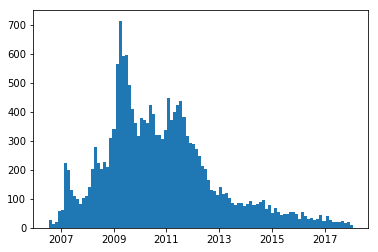

In [9]:
# Histogram of create_times, sometimes reveals things:

plt.hist(ts_list_dt,bins=100);
plt.show()

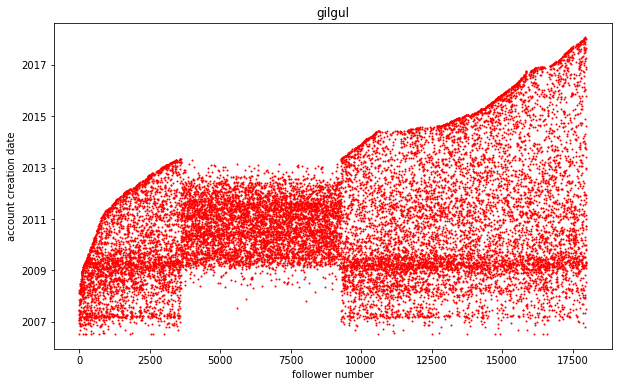

In [10]:
# The "createtime fingerprint"

start=1
stop=len(ts_list_dt)
plt.plot(range(len(ts_list_dt[start:stop])),ts_list_dt[start:stop],'r.',markersize=2);
fig = plt.gcf()
fig.set_size_inches(10, 6)
plt.xlabel('follower number')
plt.ylabel('account creation date')
plt.title(ego_screenname)
plt.show()

### Other links:

* Sune's writing on bots (2013):
https://sunelehmann.com/2013/12/04/youre-here-because-of-a-robot/

* Gilad's writing on bots (2014):
https://medium.com/i-data/fake-friends-with-real-benefits-eec8c4693bd3

In [11]:
# Clear Twython object from notebook
t = None